In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import datetime
import yfinance as yf


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import temporal_signal_split

C:\Users\akhan147\Anaconda3\envs\trader\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from pathlib import Path
data_dir = Path(r'F:\cc_data')

In [4]:
# GPU support
DEVICE = torch.device('cpu') # cuda
shuffle=True
batch_size = 32

# Data

In [5]:
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime.now()


|Rank	| Symbol |	Fund | Name |
|---|---|----|----|
|1	| SPY	| SPDR S&P 500 ETF Trust |
|2	| IVV	| iShares Core S&P 500 ETF |
|3	| VOO	| Vanguard S&P 500 ETF|
|4	| VTI	| Vanguard Total Stock Market ETF|
|5	| QQQ	| Invesco QQQ Trust Series I|
|6	| VEA	| Vanguard FTSE Developed Markets ETF|
|7	| VUG	| Vanguard Growth ETF|
|8	| VTV	| Vanguard Value ETF|
|9	| IEFA	| iShares Core MSCI EAFE ETF|
|10	| AGG	| iShares Core U.S. Aggregate Bond ETF

[Top ETFs](https://www.marketwatch.com/tools/top-25-etfs)

In [6]:
import yfinance as yf

tickers = ["SPY", "IVV", "VOO", "VTI", "QQQ", "VEA", "VUG", "VTV", "IEFA", "AGG"]

df = yf.download(tickers, start=start, end=end)
df.head()

[*********************100%***********************]  10 of 10 completed


Price                       Adj Close                                     \
Ticker                            AGG       IEFA         IVV         QQQ   
Date                                                                       
2020-01-02 00:00:00+00:00  100.104668  57.861580  302.929260  209.976089   
2020-01-03 00:00:00+00:00  100.397858  57.141922  300.599091  208.052719   
2020-01-06 00:00:00+00:00  100.317879  57.343781  301.787354  209.393234   
2020-01-07 00:00:00+00:00  100.211288  57.212139  300.961182  209.364120   
2020-01-08 00:00:00+00:00  100.095772  57.343781  302.492950  210.937805   

Price                                                                     \
Ticker                            SPY        VEA         VOO         VTI   
Date                                                                       
2020-01-02 00:00:00+00:00  302.208557  38.784153  276.999268  153.396164   
2020-01-03 00:00:00+00:00  299.920258  38.312675  274.975708  152.419846   
2020-01-06 00:00:00+00:00  301.064484  38.443645  276.006042  152.940567   
2020-01-07 00:00:00+00:00  300.217987  38.382523  275.244873  152.577942   
2020-01-08 00:00:00+00:00  301.817963  38.434921  276.665039  153.331070   

Price                                              ...   Volume            \
Ticker                            VTV         VUG  ...      AGG      IEFA   
Date                                               ...                      
2020-01-02 00:00:00+00:00  106.480400  179.231491  ...  6791400  10523100   
2020-01-03 00:00:00+00:00  105.631668  177.999695  ...  3664300   9663700   
2020-01-06 00:00:00+00:00  105.764275  179.144257  ...  8131600   7468300   
2020-01-07 00:00:00+00:00  105.357597  179.086014  ...  2883000   5815100   
2020-01-08 00:00:00+00:00  105.605141  180.492371  ...  7323100   8249700   

Price                                                                     \
Ticker                         IVV       QQQ       SPY      VEA      VOO   
Date                                                                       
2020-01-02 00:00:00+00:00  4070500  30969400  59151200  8229000  3142400   
2020-01-03 00:00:00+00:00  4290400  27518900  77709700  9697300  3247900   
2020-01-06 00:00:00+00:00  4212000  21655300  55653900  8579400  2777100   
2020-01-07 00:00:00+00:00  3632500  22139300  40496400  7884600  2251800   
2020-01-08 00:00:00+00:00  3912100  26397300  68296000  9948100  3719500   

Price                                                 
Ticker                         VTI      VTV      VUG  
Date                                                  
2020-01-02 00:00:00+00:00  3291100  1634700  1035800  
2020-01-03 00:00:00+00:00  3625400  1401600   909800  
2020-01-06 00:00:00+00:00  6813800  1546300   773700  
2020-01-07 00:00:00+00:00  2498400  1422200   848800  
2020-01-08 00:00:00+00:00  4244800  1401700   667200  

[5 rows x 60 columns]

In [7]:
df.index.min(), df.index.max()

(Timestamp('2020-01-02 00:00:00+0000', tz='UTC'),
 Timestamp('2024-09-30 00:00:00+0000', tz='UTC'))

In [8]:
df.columns

MultiIndex([('Adj Close',  'AGG'),
            ('Adj Close', 'IEFA'),
            ('Adj Close',  'IVV'),
            ('Adj Close',  'QQQ'),
            ('Adj Close',  'SPY'),
            ('Adj Close',  'VEA'),
            ('Adj Close',  'VOO'),
            ('Adj Close',  'VTI'),
            ('Adj Close',  'VTV'),
            ('Adj Close',  'VUG'),
            (    'Close',  'AGG'),
            (    'Close', 'IEFA'),
            (    'Close',  'IVV'),
            (    'Close',  'QQQ'),
            (    'Close',  'SPY'),
            (    'Close',  'VEA'),
            (    'Close',  'VOO'),
            (    'Close',  'VTI'),
            (    'Close',  'VTV'),
            (    'Close',  'VUG'),
            (     'High',  'AGG'),
            (     'High', 'IEFA'),
            (     'High',  'IVV'),
            (     'High',  'QQQ'),
            (     'High',  'SPY'),
            (     'High',  'VEA'),
            (     'High',  'VOO'),
            (     'High',  'VTI'),
            (     'H

In [9]:
df.to_csv(data_dir / 'top10_etf.csv')

In [10]:
df.shape

(1194, 60)

* `1194` : trading days
* (1194, 60) --> (1194, 10, 6, 15) 
* 1194 : num_samples,
* 10 : etfs,
* 6 : OHLC, Add CLose, Volume,
* 15 : bicket size (days), for time being only 1

In [11]:
data_numpy = df.values
data_numpy.shape

(1194, 60)

In [12]:
arrays = {}
for level in df.columns.levels[1]:
    arrays[level] = df.xs(level, axis=1, level=1).to_numpy()

In [13]:
arrays.keys()

dict_keys(['AGG', 'IEFA', 'IVV', 'QQQ', 'SPY', 'VEA', 'VOO', 'VTI', 'VTV', 'VUG'])

In [14]:
arrays['AGG'].shape

(1194, 6)

In [15]:
array_list = list(arrays.values())
array_stack = np.stack(array_list, axis=1)

train_input = np.expand_dims(array_stack, axis=-1)

train_target = array_stack[:, :, 0]
train_target = np.expand_dims(train_target, axis=-1)

train_input.shape, train_target.shape

((1194, 10, 6, 1), (1194, 10, 1))

# DataLoaders

In [16]:
# train_input = np.array(train_dataset.features) # (27399, 207, 2, 12) --> (, 10, 4, 15)
# train_target = np.array(train_dataset.targets) # (27399, 207, 12) --> (, 10, 15)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

# A3TGCN Model

In [17]:

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h) 
        h = self.linear(h)
        return h

TemporalGNN(node_features=6, periods=1, batch_size=20)

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(6, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(6, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(6, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

# Training

In [18]:
# Create model and optimizers
model = TemporalGNN(node_features=6, periods=1, batch_size=batch_size).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

print('Net\'s state_dict:')
total_param = 0
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
    total_param += np.prod(model.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
tgnn._attention 	 torch.Size([1])
tgnn._base_tgcn.conv_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_z.lin.weight 	 torch.Size([32, 6])
tgnn._base_tgcn.linear_z.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.lin.weight 	 torch.Size([32, 6])
tgnn._base_tgcn.linear_r.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.lin.weight 	 torch.Size([32, 6])
tgnn._base_tgcn.linear_h.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_h.bias 	 torch.Size([32])
linear.weight 	 torch.Size([1, 32])
linear.bias 	 torch.Size([1])
Net's total params: 6946
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 

# Train

In [19]:
num_nodes = 10

In [20]:
edge_index = torch.tensor([(i, j) for i in range(num_nodes) for j in range(num_nodes)], dtype=torch.long).t().contiguous()


In [21]:
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

# Create a StaticGraphTemporalSignal object
dataset = StaticGraphTemporalSignal(edge_index=edge_index, edge_weight=None, features=[train_input], targets=[train_target])

In [22]:
for snapshot in dataset:
    print(snapshot.x.shape, snapshot.edge_index.shape)
    break

torch.Size([1194, 10, 6, 1]) torch.Size([2, 100])


In [23]:
for snapshot in dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    break;

In [25]:
model.train()

for epoch in range(5001):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs, static_edge_index)         # Get model predictions
        loss = loss_fn(y_hat, labels) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        loss_list.append(loss.item())
        if step % 100 == 0 :
            print(sum(loss_list)/len(loss_list))
    if epoch % 100 == 0 :
        print("Epoch {} train RMSE: {:.4E}".format(epoch, sum(loss_list)/len(loss_list)))

Epoch 0 train RMSE: 2.0692E+04
Epoch 100 train RMSE: 2.0727E+04
Epoch 200 train RMSE: 2.0705E+04
Epoch 300 train RMSE: 2.0709E+04
Epoch 400 train RMSE: 2.0690E+04
Epoch 500 train RMSE: 2.0730E+04
Epoch 600 train RMSE: 2.0674E+04
Epoch 700 train RMSE: 2.0718E+04
Epoch 800 train RMSE: 2.0683E+04
Epoch 900 train RMSE: 2.0749E+04
Epoch 1000 train RMSE: 2.0645E+04
Epoch 1100 train RMSE: 2.0724E+04
Epoch 1200 train RMSE: 2.0648E+04
Epoch 1300 train RMSE: 2.0725E+04
Epoch 1400 train RMSE: 2.0707E+04
Epoch 1500 train RMSE: 2.0659E+04
Epoch 1600 train RMSE: 2.0695E+04
Epoch 1700 train RMSE: 2.0727E+04
Epoch 1800 train RMSE: 2.0711E+04
Epoch 1900 train RMSE: 2.0679E+04
Epoch 2000 train RMSE: 2.0665E+04
Epoch 2100 train RMSE: 2.0655E+04
Epoch 2200 train RMSE: 2.0741E+04
Epoch 2300 train RMSE: 2.0696E+04
Epoch 2400 train RMSE: 2.0737E+04
Epoch 2500 train RMSE: 2.0738E+04
Epoch 2600 train RMSE: 2.0667E+04
Epoch 2700 train RMSE: 2.0693E+04
Epoch 2800 train RMSE: 2.0716E+04
Epoch 2900 train RMSE: 2.0

# Eval

In [27]:
model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in train_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

Test MSE: 20705.5338


In [30]:
sensor = 9
timestep = 0
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (32,)


<Axes: >

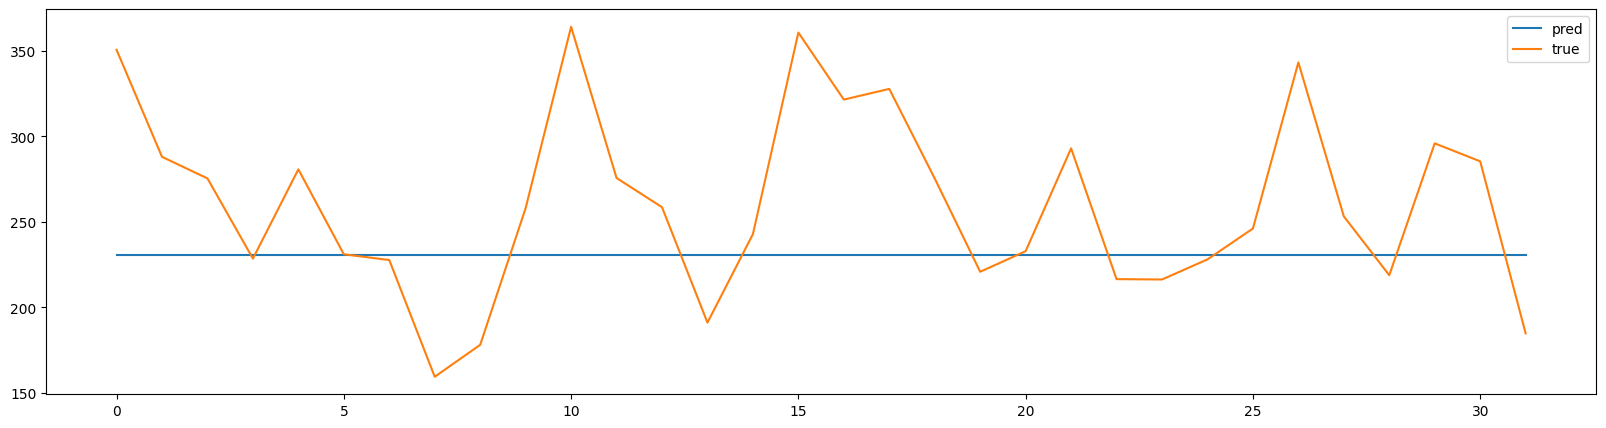

In [31]:

plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")